# Vavilov Dmitry

# Opinion Sharing Modelling 

Original research: [link](http://jasss.soc.surrey.ac.uk/5/4/1.html)

In [1]:
from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.time import SimultaneousActivation

import numpy as np

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [2]:
class OpinionAgent(Agent):
    def __init__(self, unique_id, x, unc, mu, model):
        super().__init__(unique_id, model)
        self.opinion = x
        self.unc = unc
        self.mu = mu        
        
    def collect_opinions(self):
        opinion_contr = []
        unc_contr = [] # lists to collect influences 
        
        for agent in model.schedule.agents: # going through all agents
            if agent != self:
                overlap = min(agent.opinion + agent.unc, self.opinion + self.unc) - \
                    max(agent.opinion - agent.unc, self.opinion - self.unc) #overlap
                if overlap <= agent.unc:
                    continue # no influence in this case
                else:  
                    non_overlap = 2 * agent.unc - overlap
                    agreement = overlap - non_overlap
                    relative_agreement = agreement / (2 * agent.unc)

                    opinion_change = self.mu * relative_agreement * (agent.opinion - self.opinion)
                    unc_change = self.mu * relative_agreement * (agent.unc - self.unc)

                    opinion_contr.append(opinion_change)
                    unc_contr.append(unc_change)

                    total_opinion_change = np.sum(opinion_contr)
                    total_unc_change = np.sum(unc_contr)
                    
                    return (total_opinion_change, total_unc_change)
            
    def step(self):
        self.total_opinion_change, self.total_unc_change = self.collect_opinions()  
        
    def advance(self):
        self.opinion += self.total_opinion_change
        self.unc += self.total_unc_change

In [3]:
class OpinionModel(Model):
    def __init__(self, N, p_ext, unc_mod, unc_ext, sigma, mu, eps=1e-5, seed=None):
        self.num_agents = N
        self.p_ext = p_ext
        self.unc_mod = unc_mod
        self.unc_ext = unc_ext
        self.sigma = sigma
        self.mu = mu
        self.eps = eps
        
        self.schedule = SimultaneousActivation(self)
        
        p_pos = (p_ext - sigma * p_ext) / 2
        p_neg = p_ext - p_pos 
        
        np.random.seed(seed)
        self.all_opinions = np.random.uniform(-1, 1, N)

        # Create agents
        for i, opinion in enumerate(self.all_opinions):
            if opinion > np.quantile(self.all_opinions, 1-p_pos): # "ultra high" agents
                a = OpinionAgent(i, opinion, self.unc_ext, self.mu, self)
            elif opinion < np.quantile(self.all_opinions, p_neg): # "ultra low" agents
                a = OpinionAgent(i, opinion, self.unc_ext, self.mu, self)
            else:                                                 # "moderate" agents
                a = OpinionAgent(i, opinion, self.unc_mod, self.mu, self)
            self.schedule.add(a)

        self.datacollector = DataCollector(
            agent_reporters={"Opinion": "opinion"}
        )
             

    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        
        
        no_change_agents = (abs(self.datacollector.get_agent_vars_dataframe().groupby(level=1)['Opinion'].diff()) < self.eps).\
                    groupby(level=0).sum()
        all_no_changes = no_change_agents == model.num_agents 
        self.in_a_row = 0
        for all_n0_change in all_no_changes:
            if all_n0_change == True: 
                self.in_a_row += 1
            else: 
                self.in_a_row = 0

In [13]:
def plot_model_results(model, step, eps=1e-5, in_a_row=5): 
    agent_opinions = model.datacollector.get_agent_vars_dataframe()
    plt.figure(figsize=(16, 8))
    for i in range(model.num_agents): 
        plt.plot(agent_opinions.xs(i, level="AgentID"), color='blue', alpha=0.2)
    plt.xlabel('Step of Model')
    plt.ylabel('Opinion')
    plt.title('Opinion Change')
    if step: 
        plt.axvline(x=step, color='red', linestyle='--', 
                    label=f'Change of each agent is less than {eps} {in_a_row} times in a row')
        plt.legend()
    plt.show()    

Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


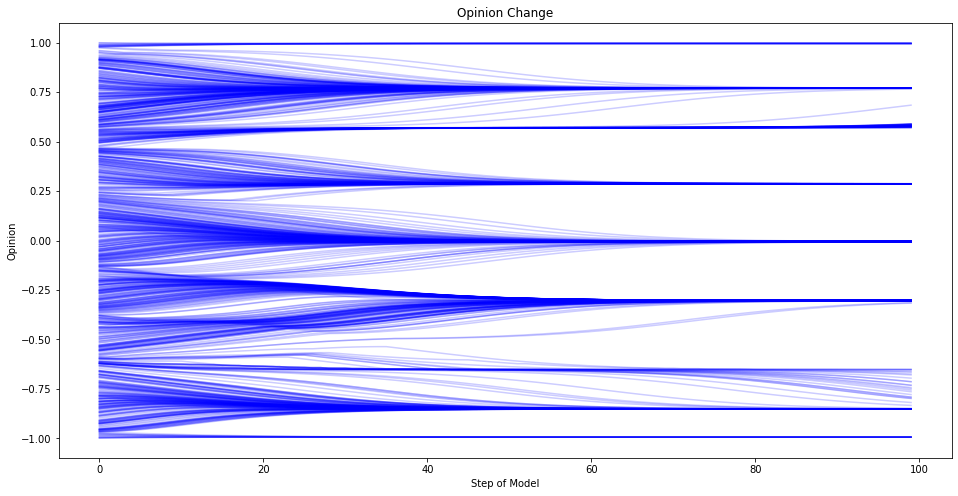


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.5


Detected convergence as step 51


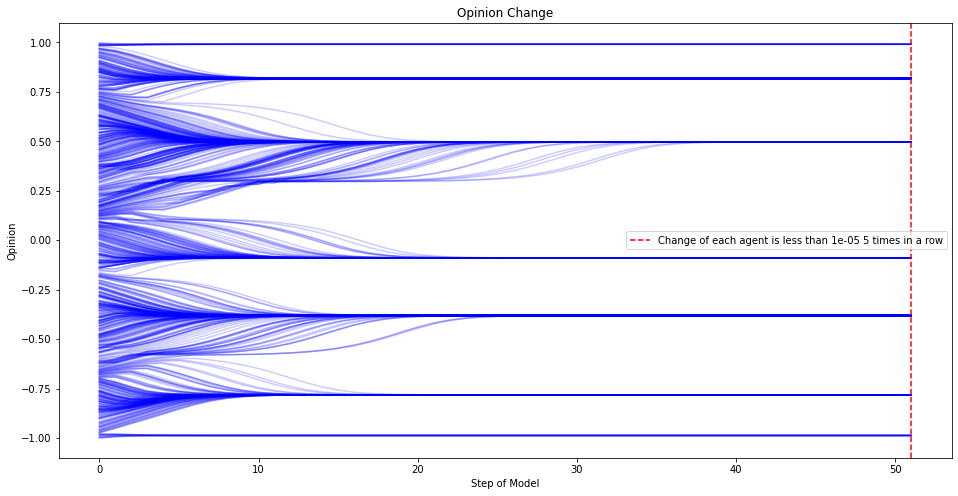


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


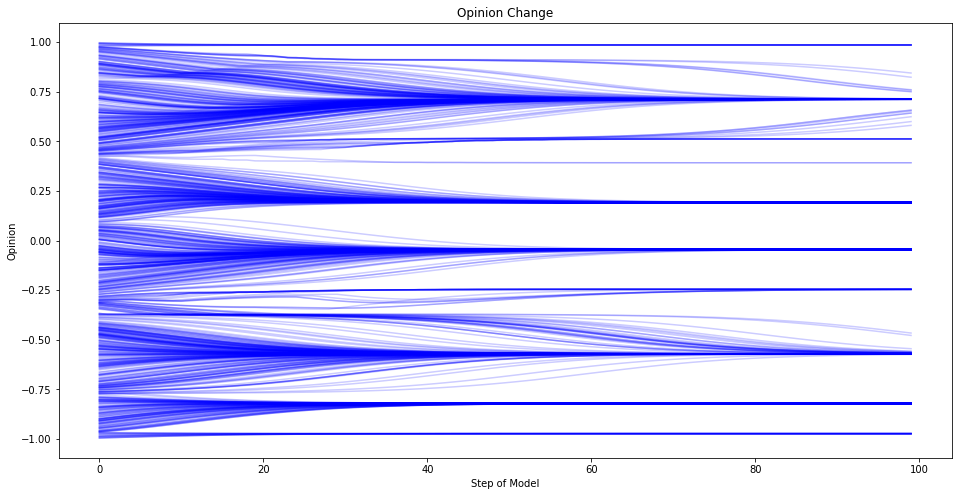


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.5


Detected convergence as step 40


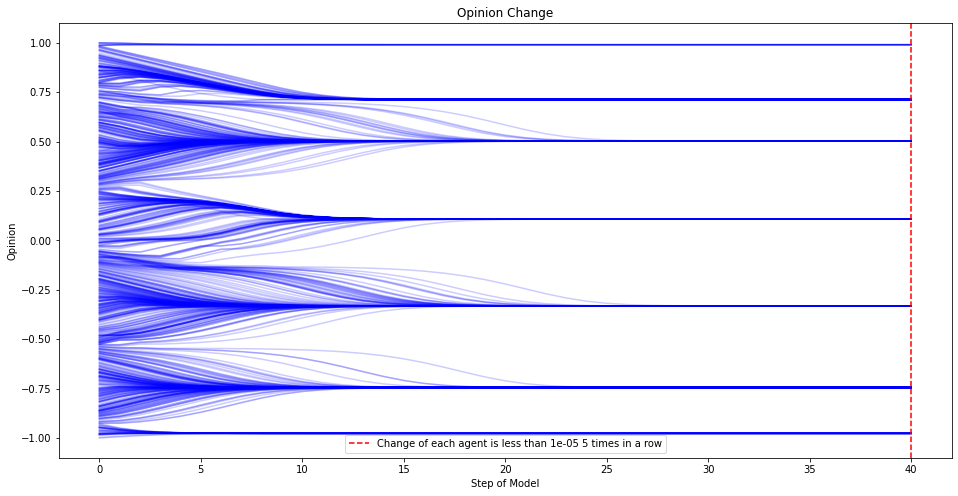


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


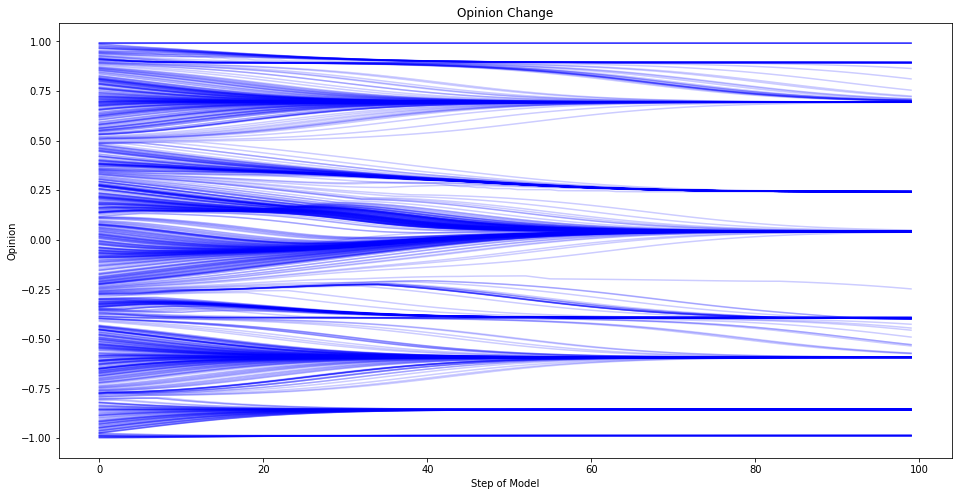


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.5


Detected convergence as step 60


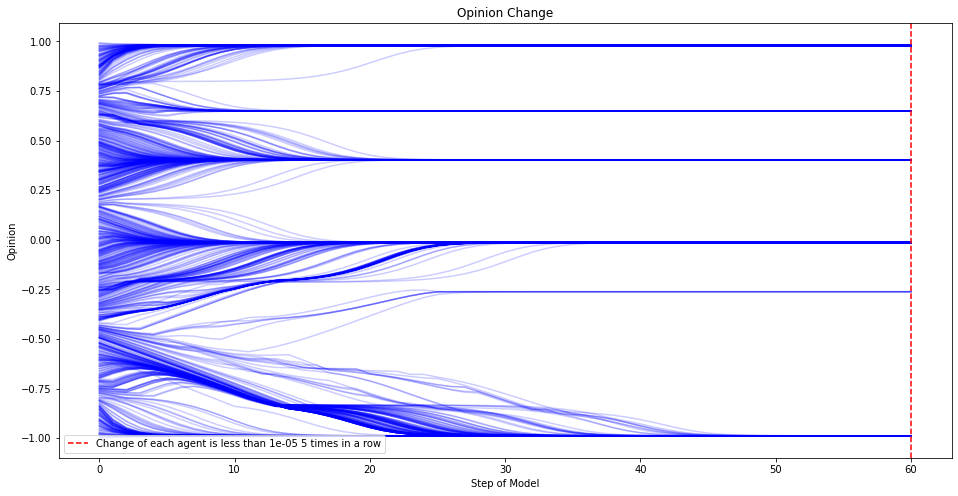


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


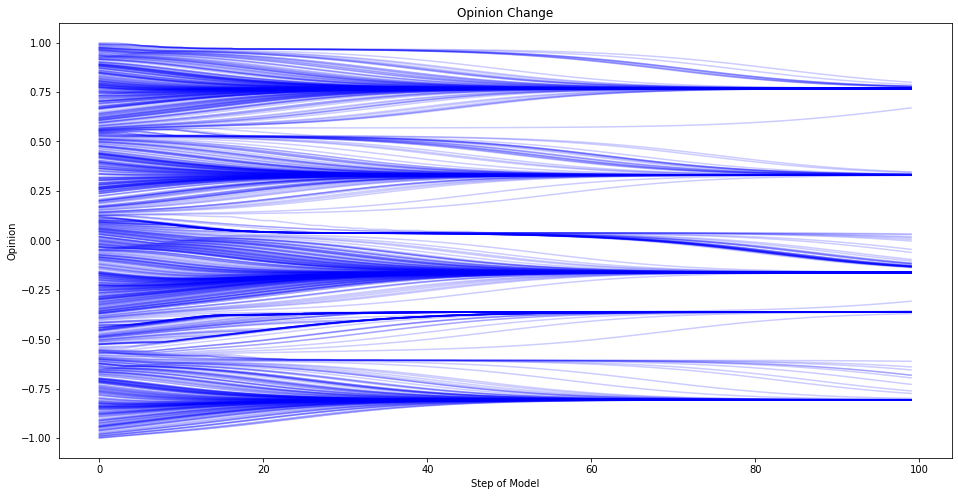


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.5


Detected convergence as step 50


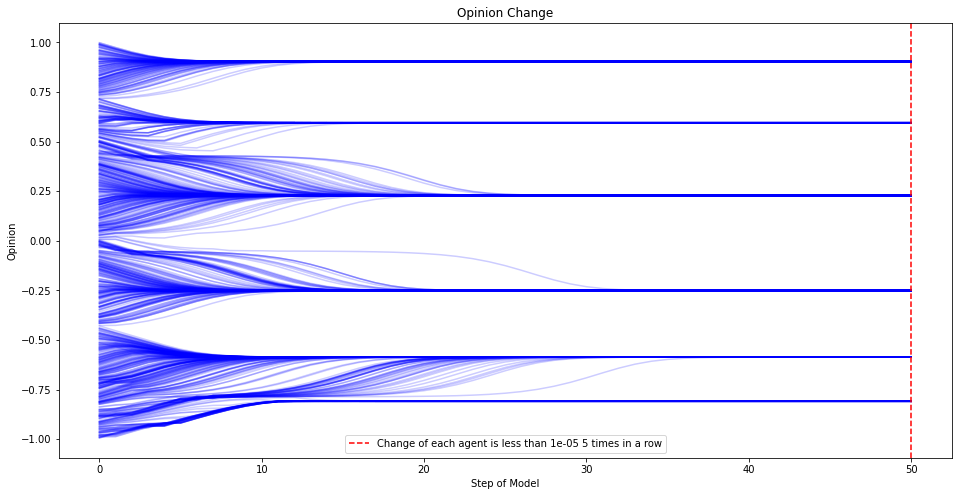


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


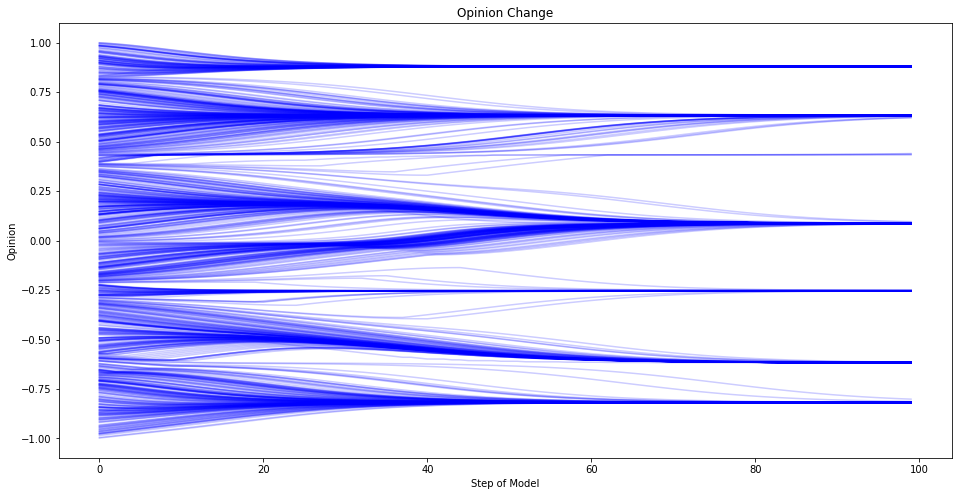


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.5


Detected convergence as step 49


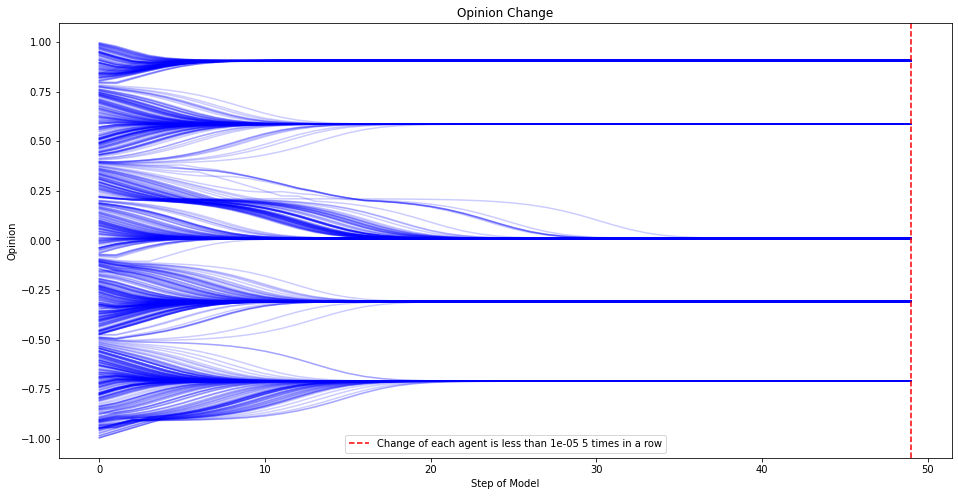


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


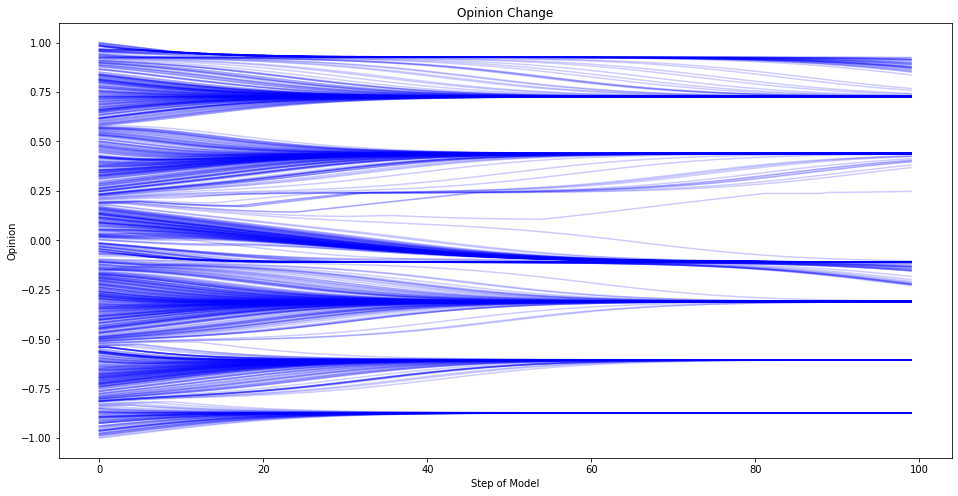


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.5


Detected convergence as step 53


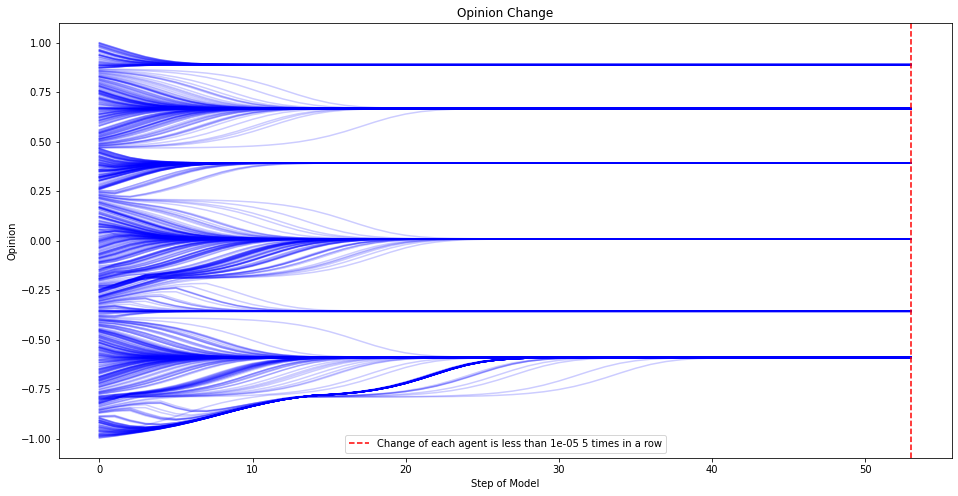


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


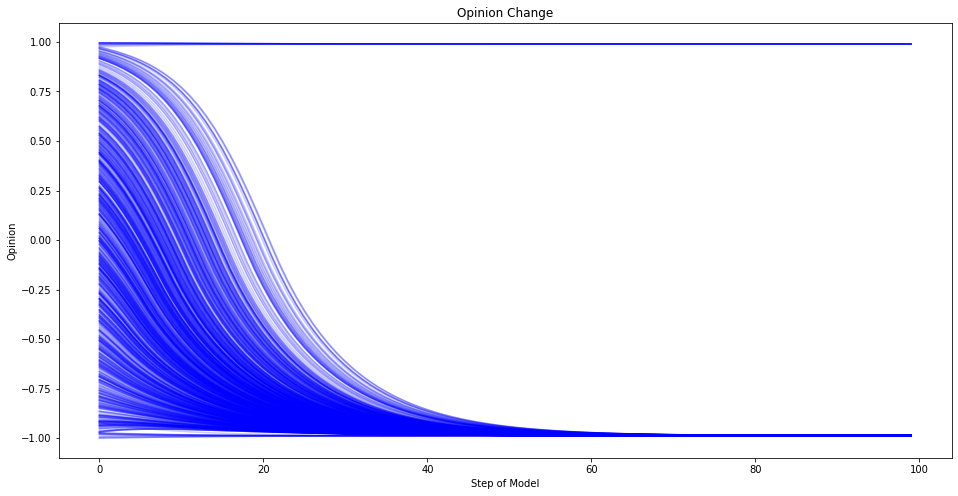


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.5


Detected convergence as step 26


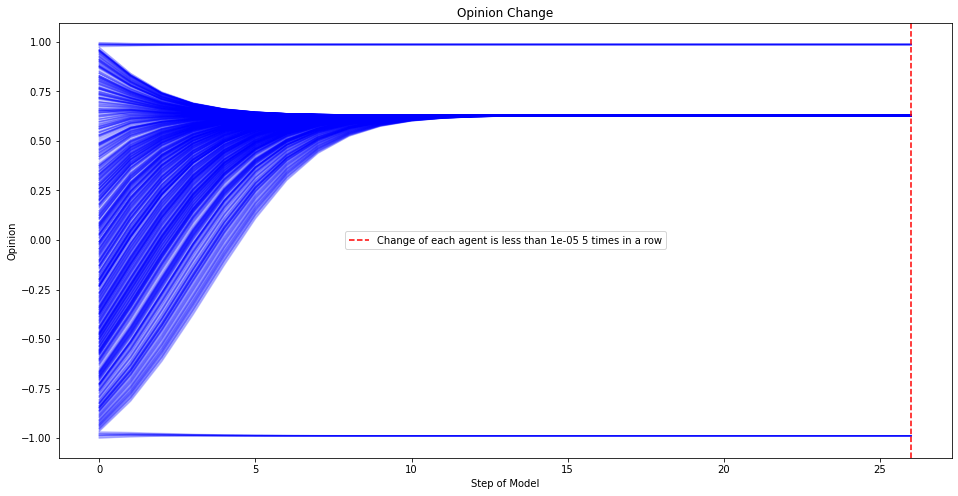


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


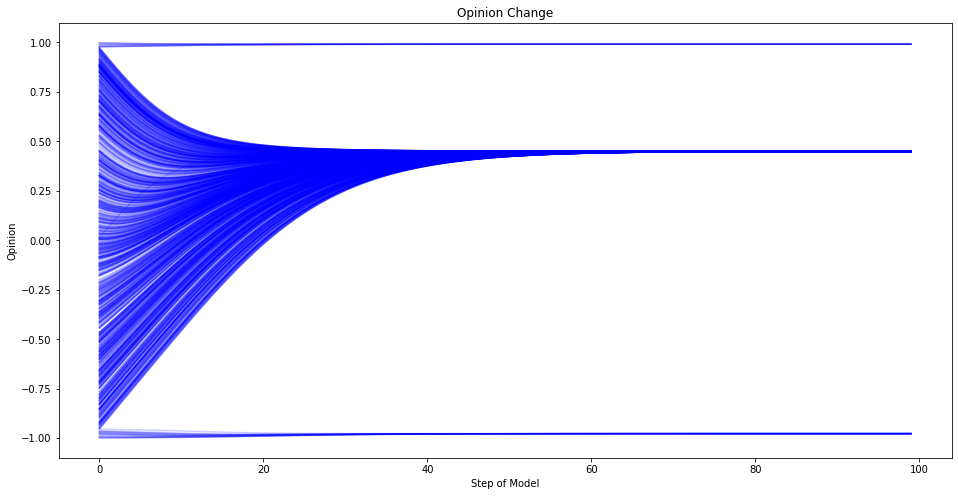


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.5


Detected convergence as step 23


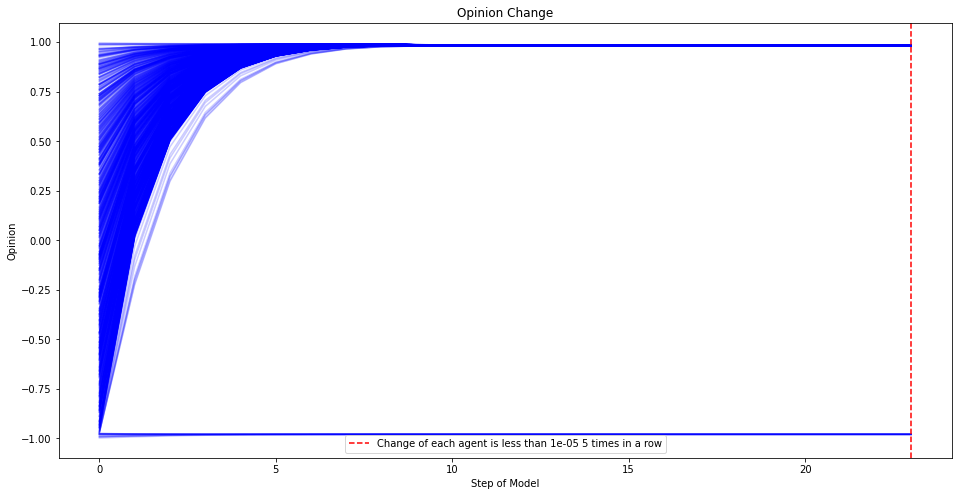


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


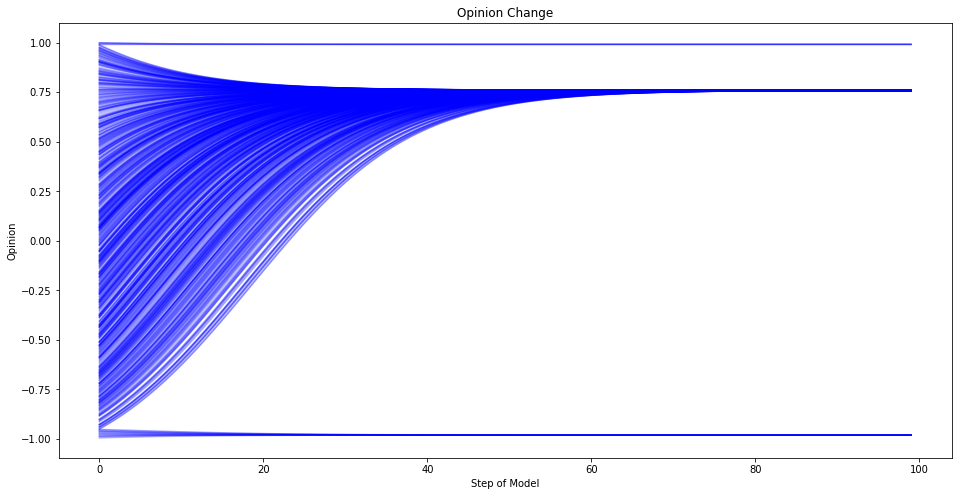


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.5


Detected convergence as step 25


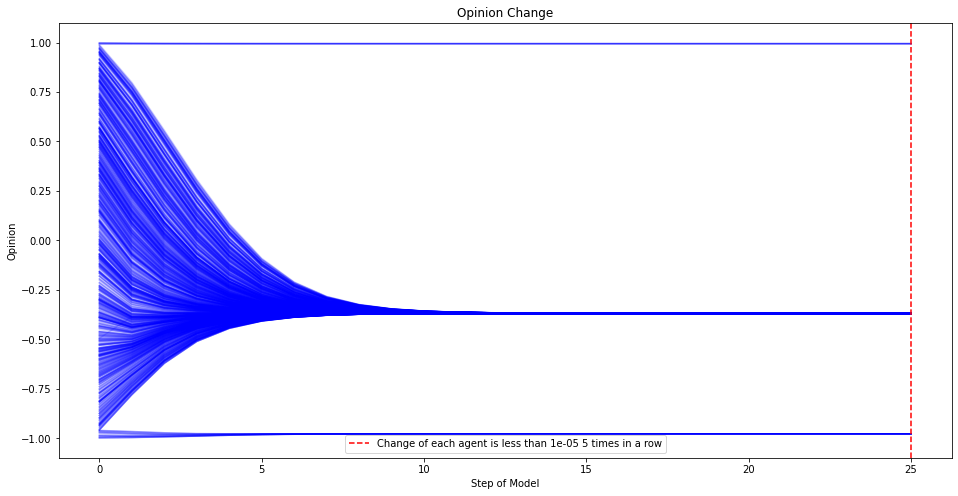


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


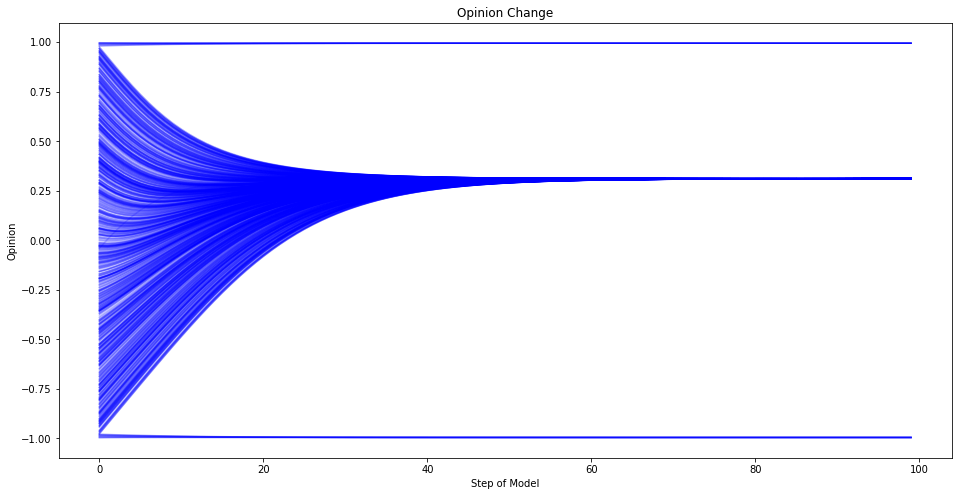


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.5


Detected convergence as step 24


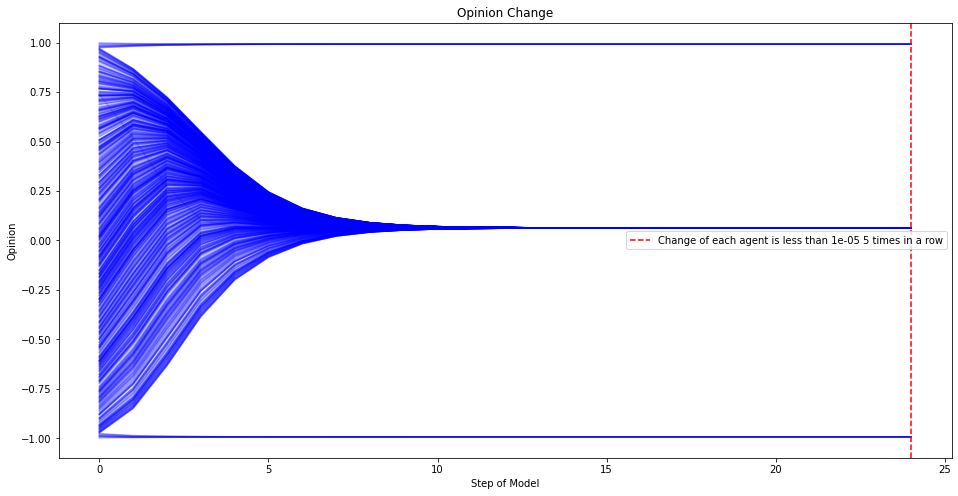


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


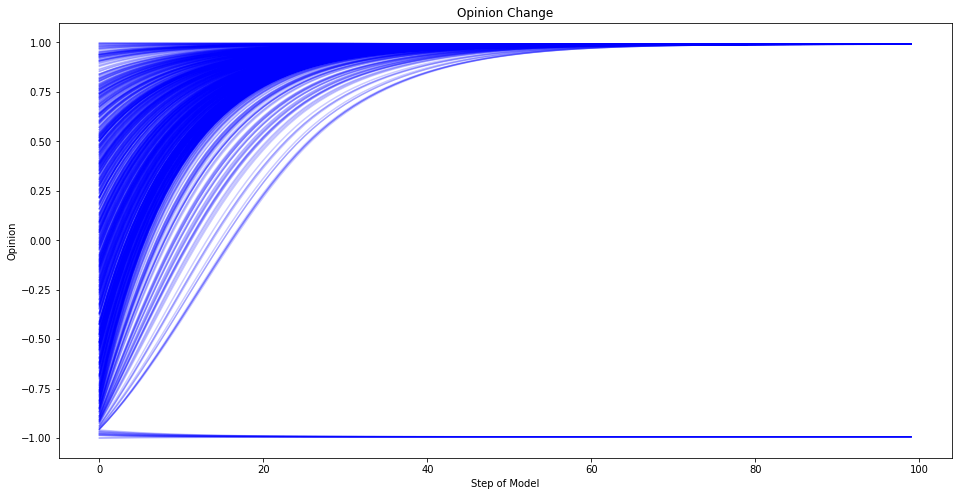


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.5


Detected convergence as step 25


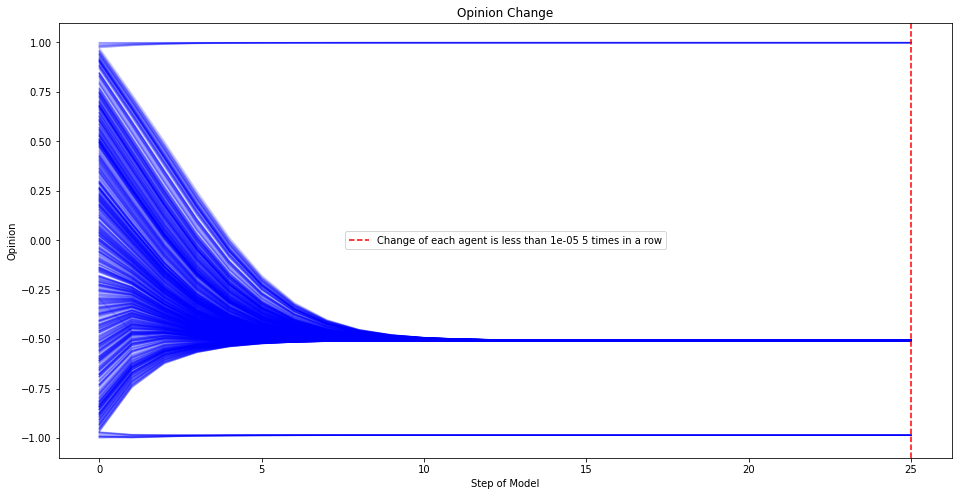


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


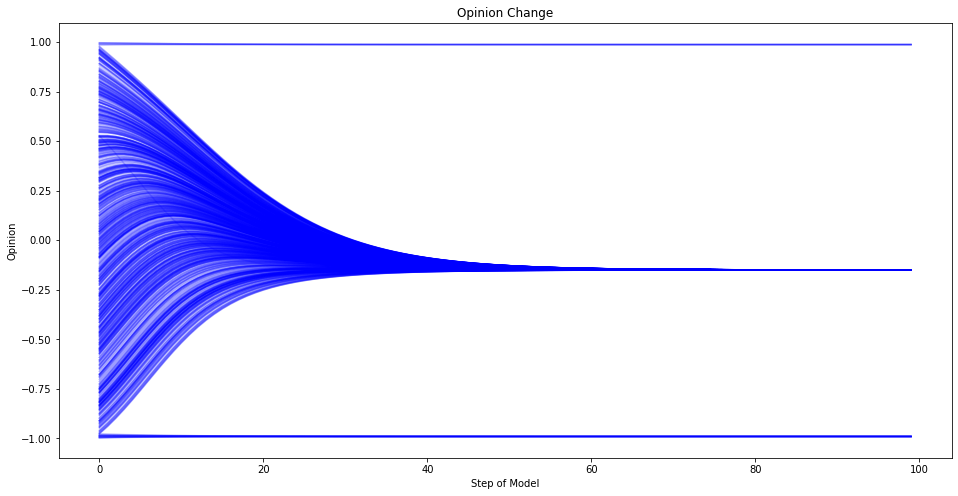


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.025
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.5


Detected convergence as step 25


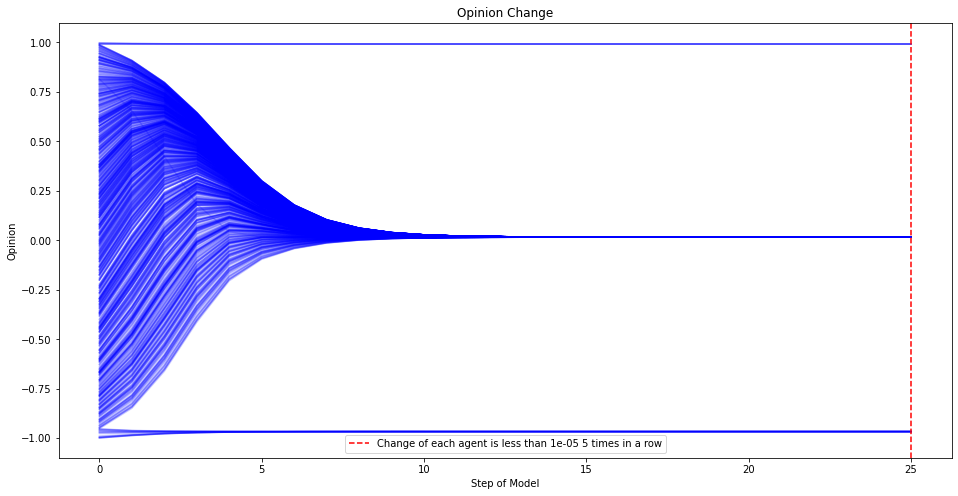


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


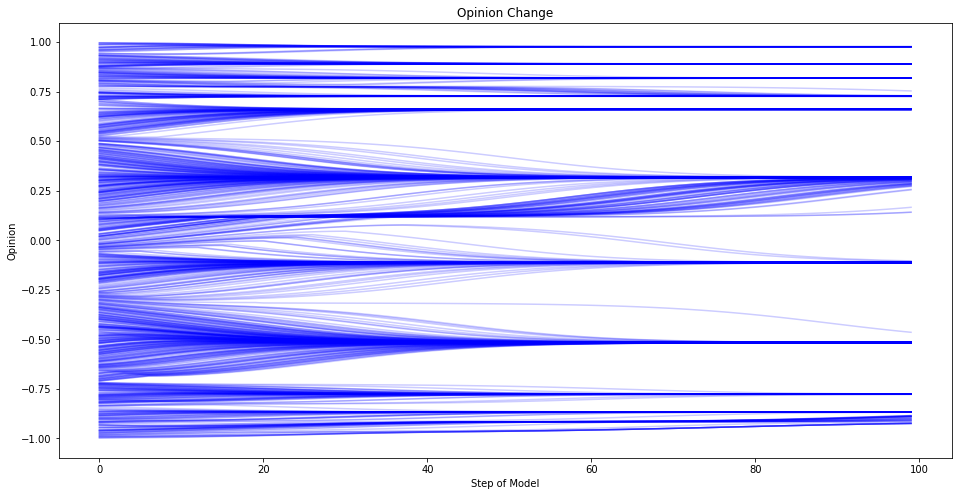


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.5


Detected convergence as step 56


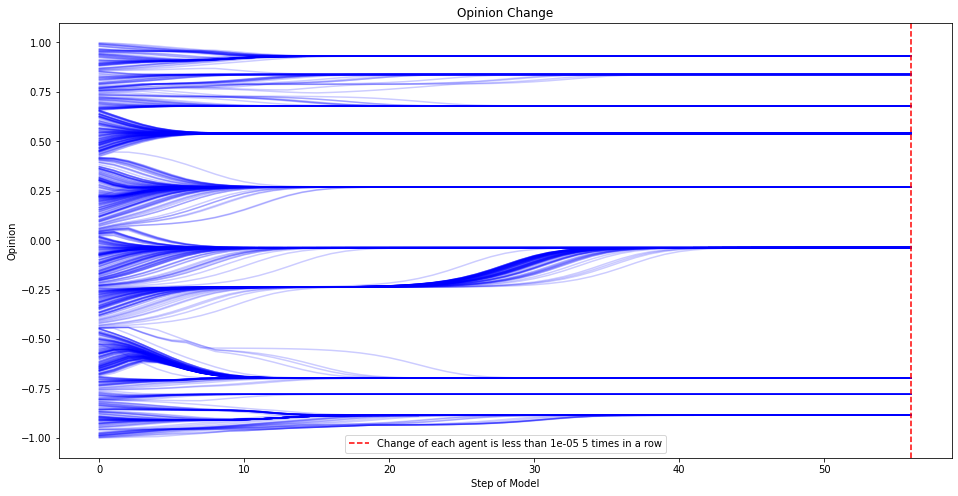


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


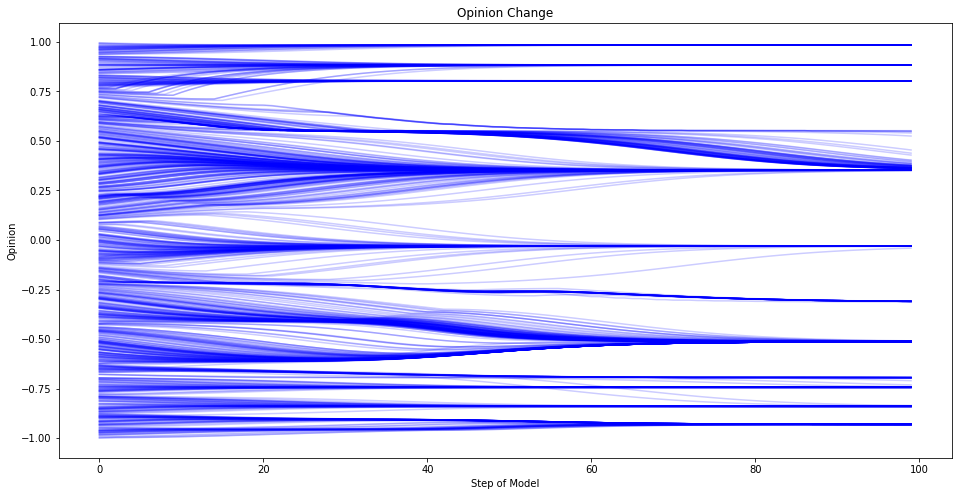


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.5


Detected convergence as step 40


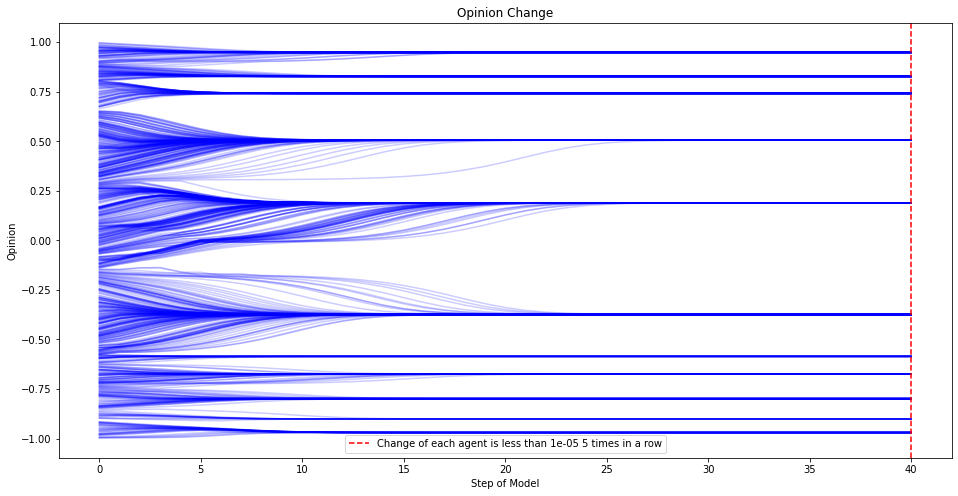


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


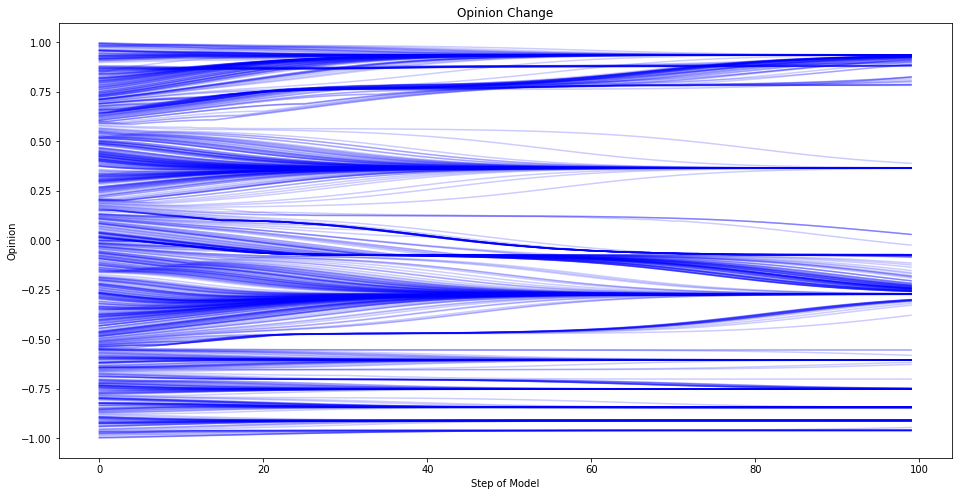


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.5


Detected convergence as step 53


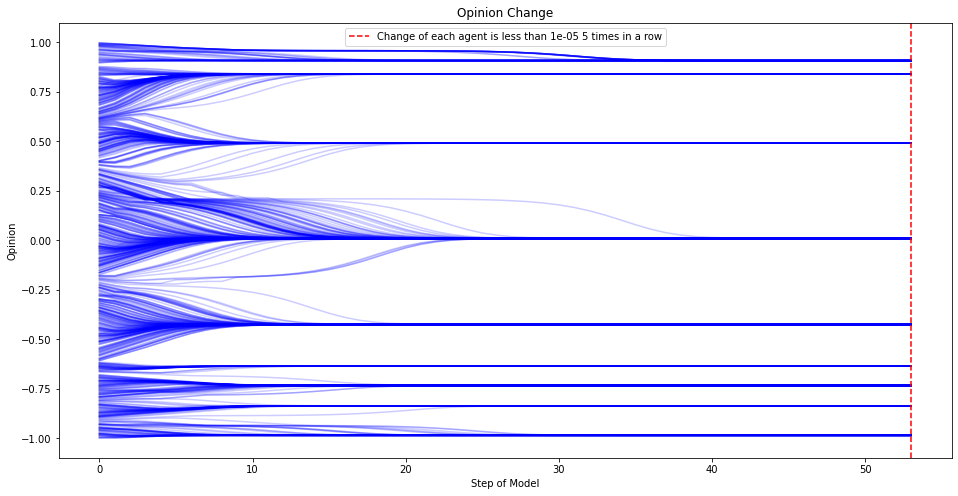


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


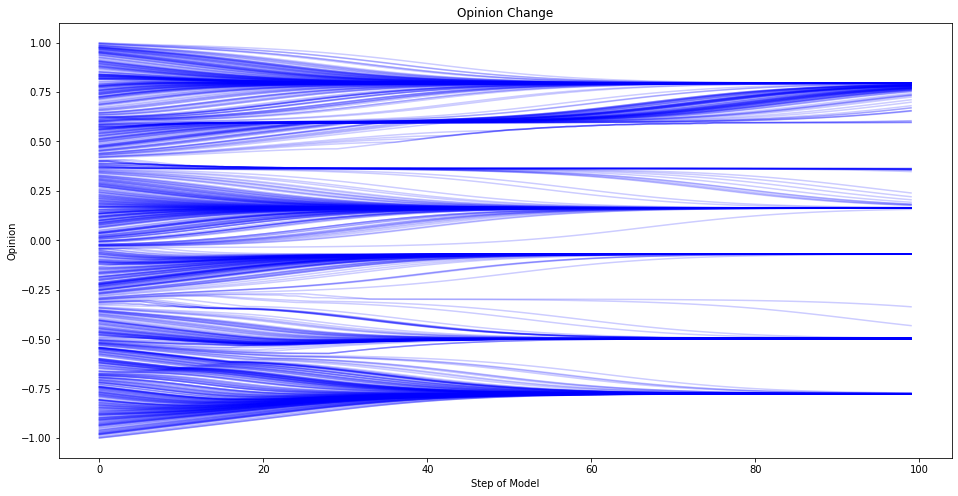


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.5


Detected convergence as step 46


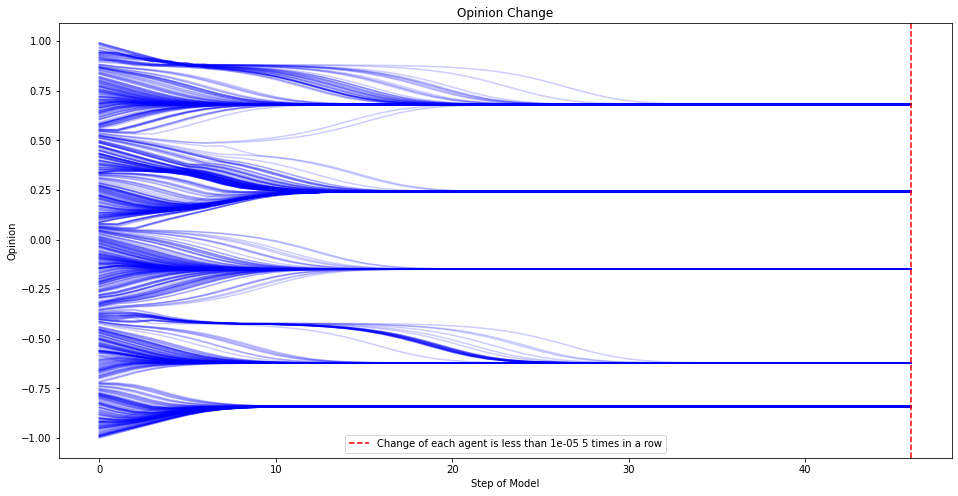


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


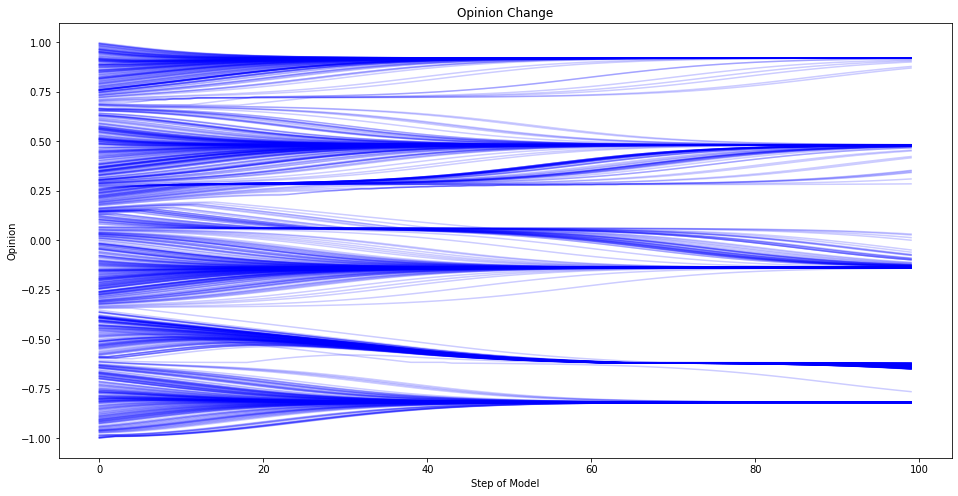


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.5


Detected convergence as step 64


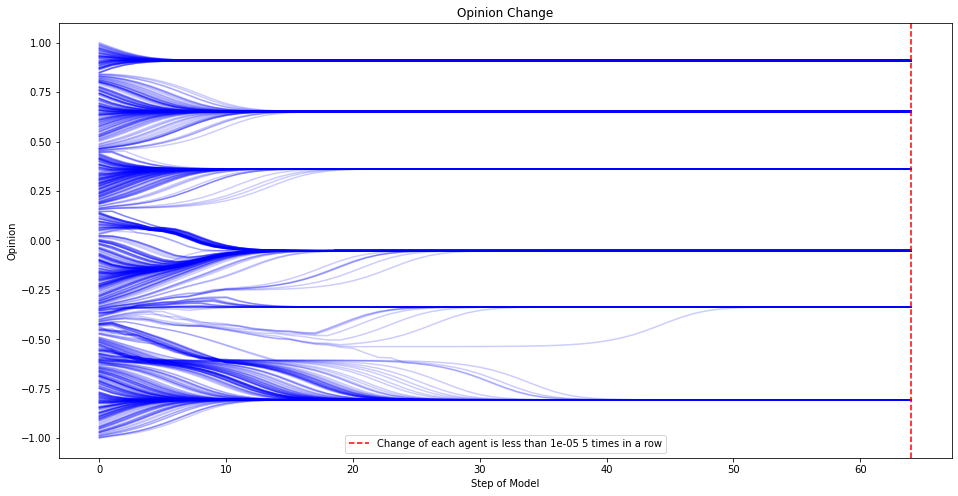


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


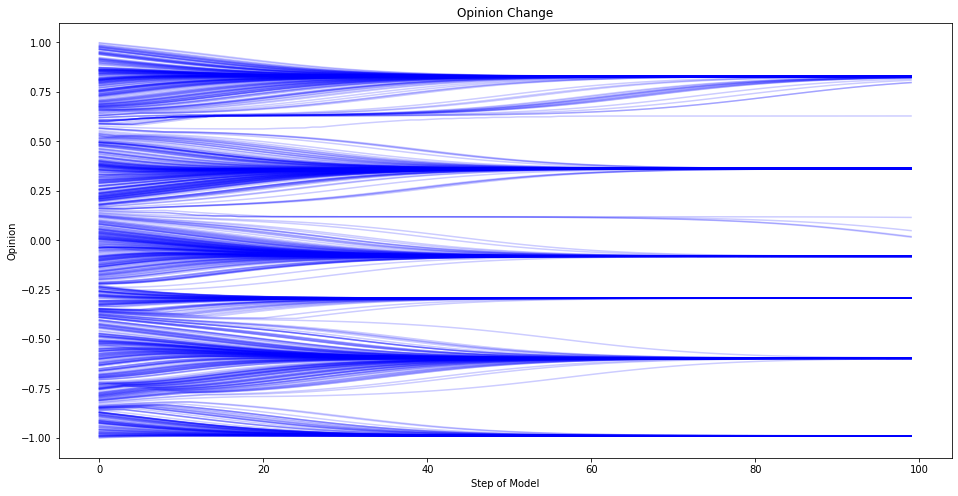


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 0.2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.5


Detected convergence as step 47


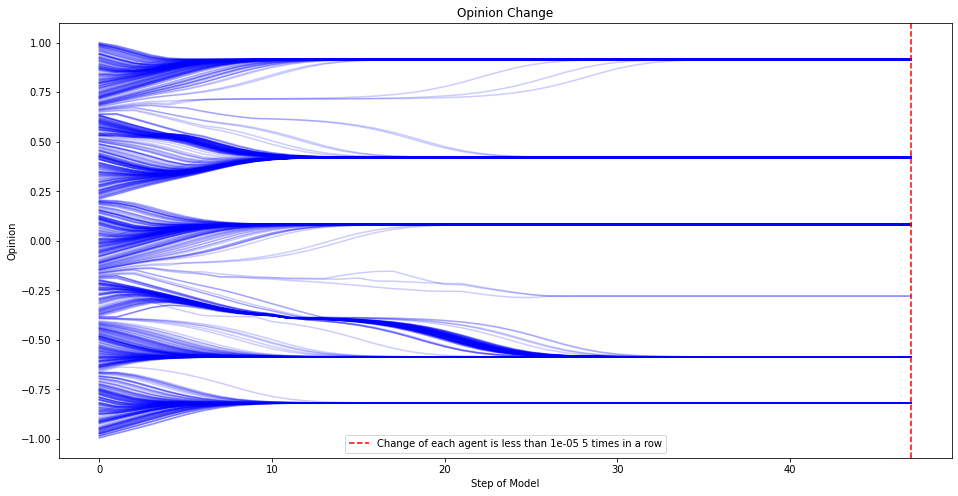


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


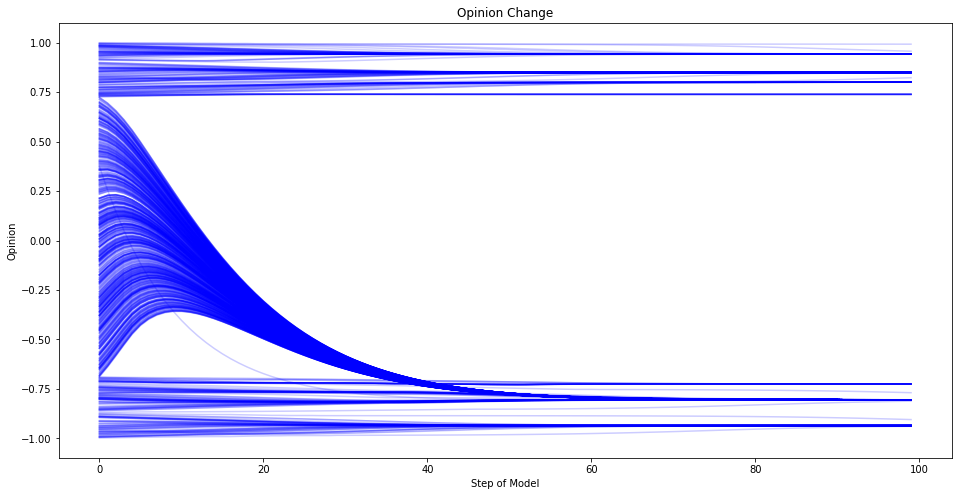


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.5


Detected convergence as step 48


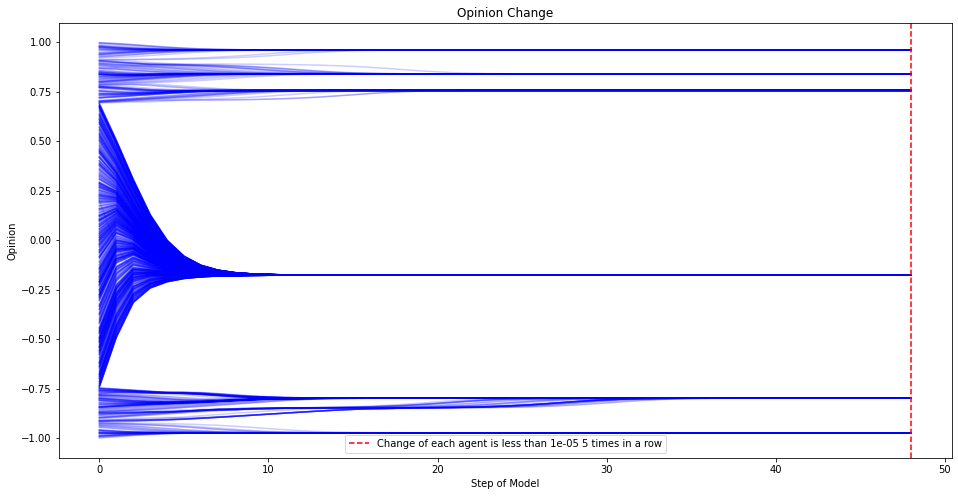


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


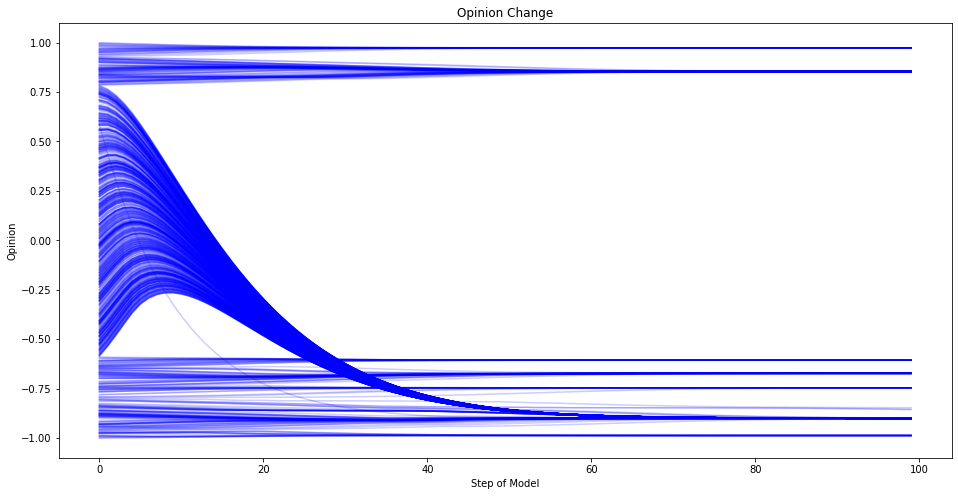


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.5


Detected convergence as step 49


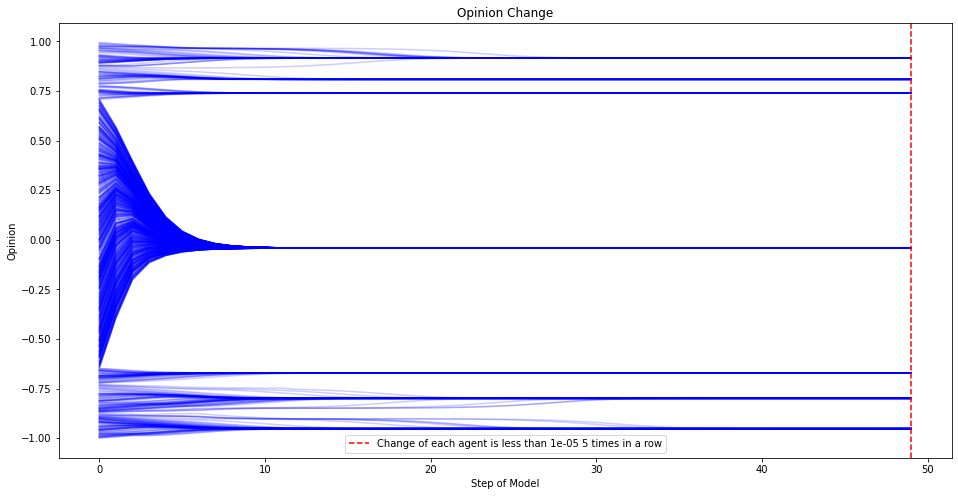


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


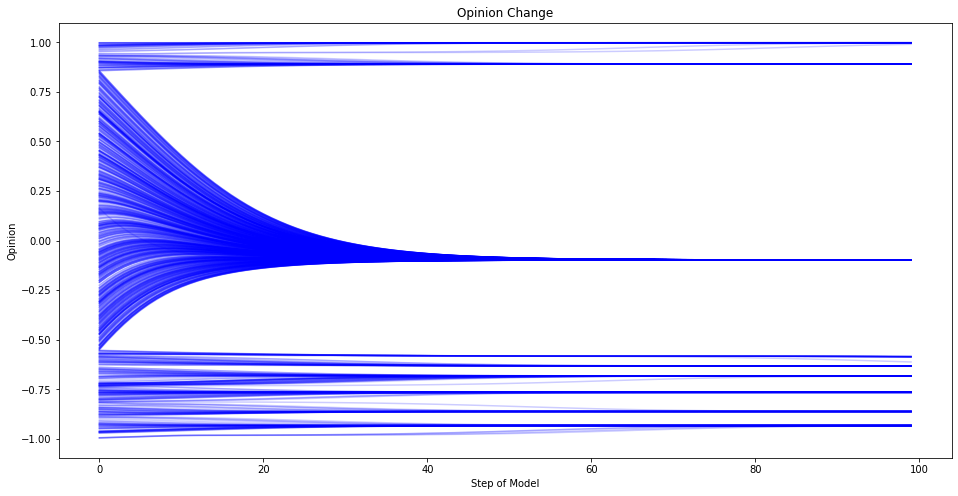


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.05
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.5


Detected convergence as step 72


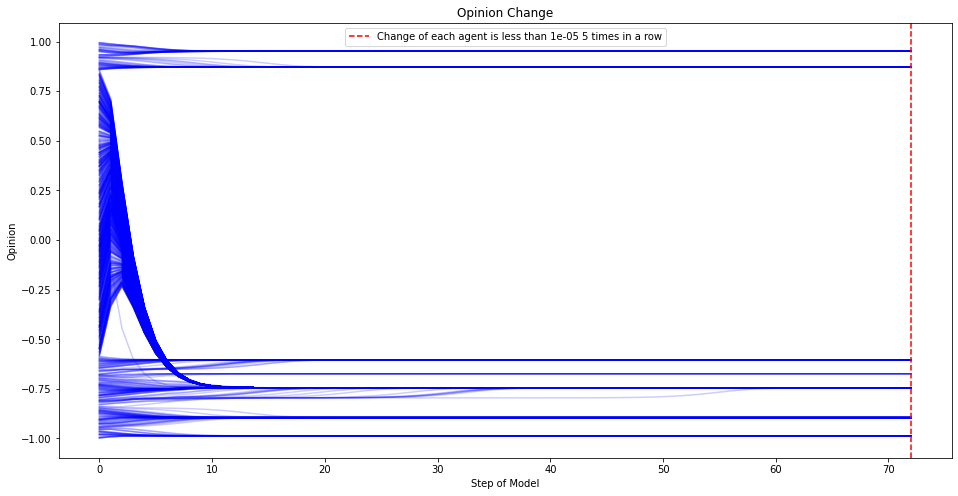


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


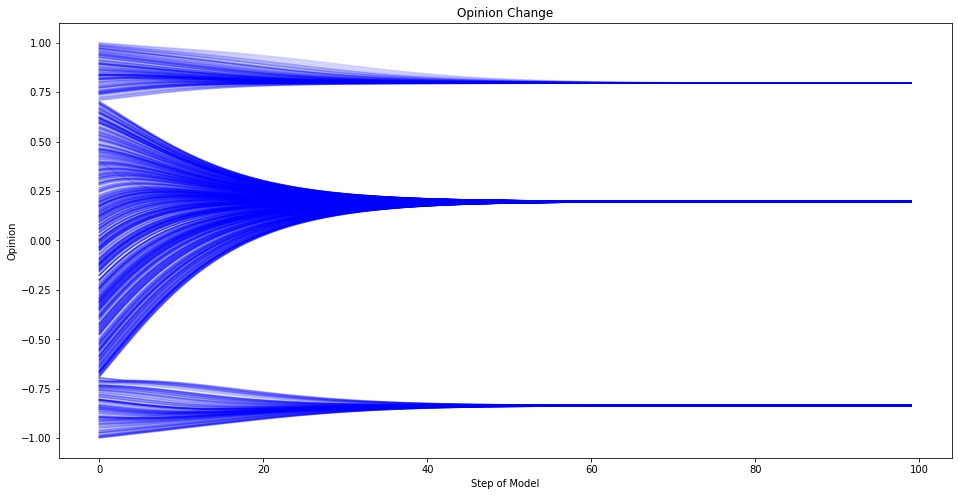


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0
Intensity of interactions: 0.5


Detected convergence as step 26


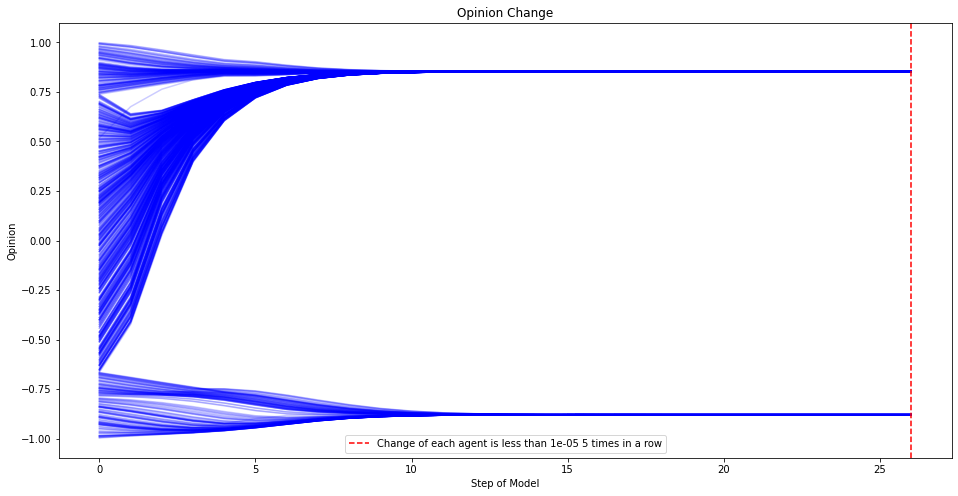


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


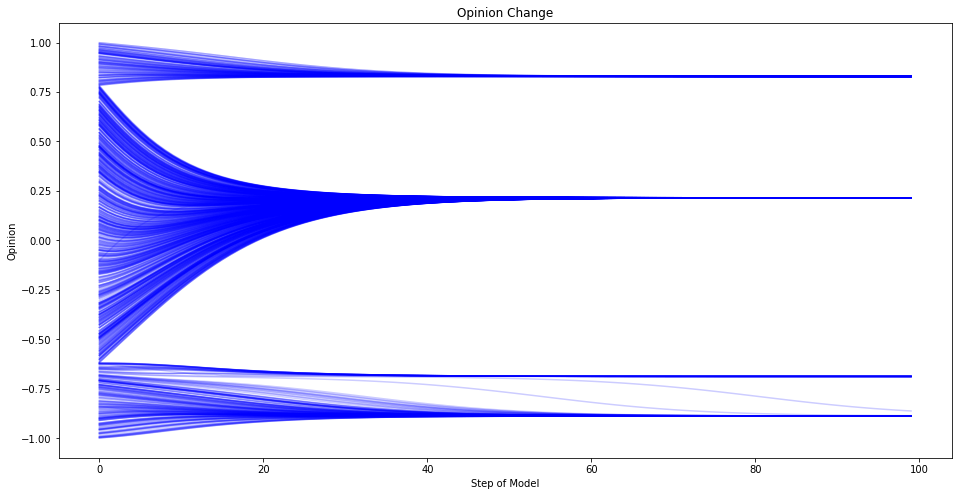


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.25
Intensity of interactions: 0.5


Detected convergence as step 35


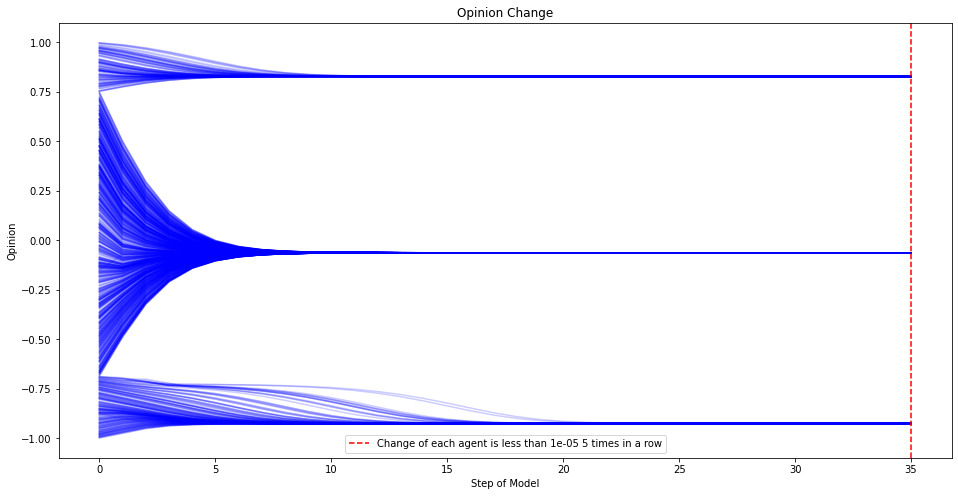


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.1


Convergence was not detected during 100 steps


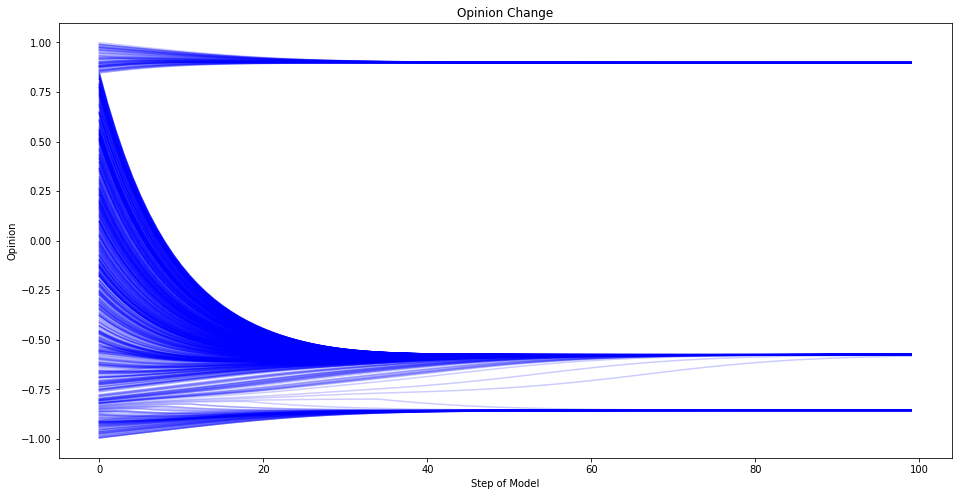


------------------------------------------------------------------------------------------------------------------------
Starting opinion modelling with parameters:
Global proportion of extremists: 0.3
Initial uncertainty of the moderate agents: 2
Initial uncertainty of the extremists: 0.2
Relative difference between the proportion of positive and negative extremists: 0.5
Intensity of interactions: 0.5


Detected convergence as step 48


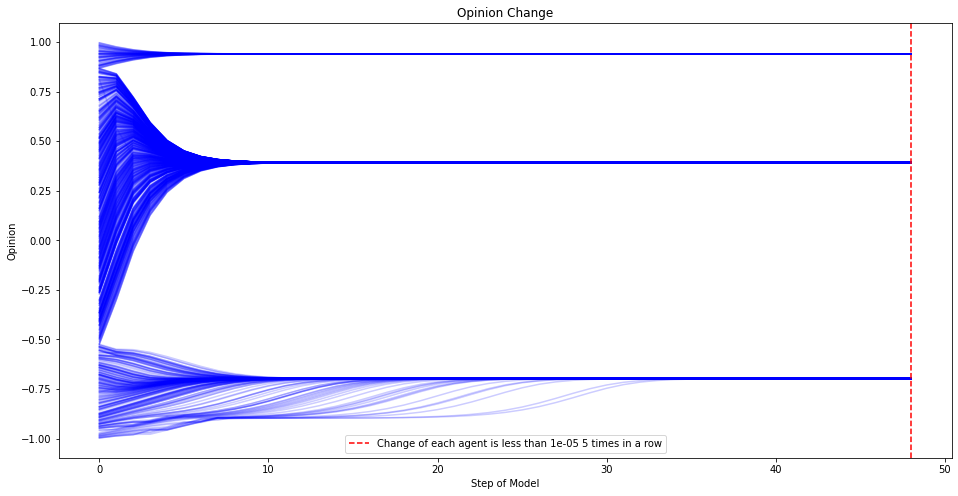


------------------------------------------------------------------------------------------------------------------------


In [14]:
max_iter = 100
N = 1000

in_a_row_for_convergence = 5
eps = 1e-5

for p_ext in [0.025, 0.3]:
    for unc_mod in [0.2, 2]:
        for unc_ext in [0.05, 0.2]:
            for sigma in [0, 0.25, 0.5]:
                for mu in [0.1, 0.5]:

        

                    model = OpinionModel(N, p_ext, unc_mod, unc_ext, sigma, mu, eps)
                    print('Starting opinion modelling with parameters:')
                    print(f'Global proportion of extremists: {p_ext}')
                    print(f'Initial uncertainty of the moderate agents: {unc_mod}')
                    print(f'Initial uncertainty of the extremists: {unc_ext}')
                    print(f'Relative difference between the proportion of positive and negative extremists: {sigma}')
                    print(f'Intensity of interactions: {mu}')
                    for i in tqdm(range(max_iter)): 
                        model.step()
                        if model.in_a_row == in_a_row_for_convergence:
                            print(f'Detected convergence as step {i}')
                            plot_model_results(model, i)
                            break
                        if i == max_iter-1:
                            print(f'Convergence was not detected during {max_iter} steps')
                            plot_model_results(model, None, in_a_row_for_convergence)
                    print('--'*60)